In [1]:
# in case there are any problems with importing because path is wrong
import sys
sys.path.append('C:/Users/nerpa\Dropbox (Personal)\Research\discrete_sr\code\python\SPIDER_discrete')

In [2]:
import numpy as np

from commons.weight import *
from utils import save, load
from library import *
from process_library_terms import *

In [3]:
import netCDF4 as nc

dataset = 'viscek/dt=1_rho=1_v=0.5_alpha=0.25_eta=0.2_N=100000.nc'
#dataset = 'viscek/dt=1_rho=1_v=0.5_alpha=0.25_eta=0.15_N=100000'
ds = nc.Dataset(dataset)
print(ds)

nt = len(ds.dimensions["time"])
n_particles = len(ds.dimensions["director"])
deltat = 1
v = 0.5
positions = np.array(ds.variables["position"]).T
positions = np.reshape(positions, (n_particles, 2, nt))
positions -= np.min(positions[:]) # recenter positions to [0, L]
directors = np.array(ds.variables["director"])
vs = v*np.stack([np.cos(directors), np.sin(directors)], axis=1).T
print(directors.shape)
print(positions.shape)
print(vs.shape)
dims = [np.max(positions[:]), nt]
world_size = np.array([dims[0], dims[0], dims[1]])
print(world_size)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): Nv(100000), dof(200000), boxdim(4), unit(1), position(200000), director(100000), time(50)
    variables(dimensions): float32 time(time), float32 position(time, position), float32 director(time, director)
    groups: 
(50, 100000)
(100000, 2, 50)
(100000, 2, 50)
[316.22769165 316.22769165  50.        ]


0
0
0
10
20
30
40


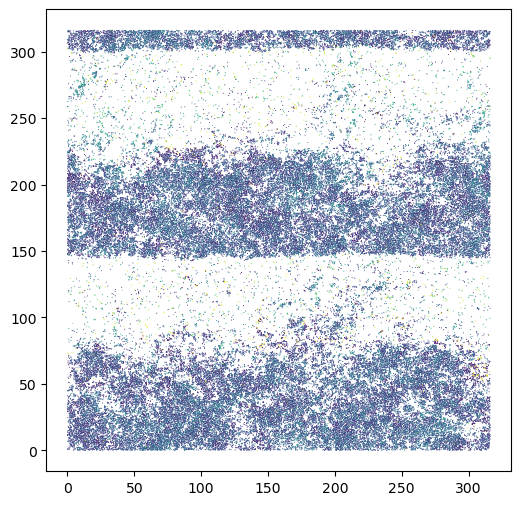

In [29]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = 'C:/Users/nerpa/Downloads/ffmpeg-6.0-essentials_build/bin/ffmpeg.exe'

vid_file = 'viscek/eta0.2.mp4'

fig, ax = plt.subplots(figsize=(6, 6))
qv = ax.quiver(positions[:, 0, -1], positions[:, 1, -1], 1, 0, clim=[-np.pi, np.pi])

def animate(i):
    if i % 10 == 0:
        print(i)
    qv.set_offsets(positions[:, :, i])
    norms = np.sqrt(vs[:, 0, i] ** 2 + vs[:, 1, i] ** 2)
    qv.set_UVC(vs[:, 0, i] / norms, vs[:, 1, i] / norms, np.angle(vs[:, 0, i] + 1.0j * vs[:, 1, i]))
    return qv,

anim = FuncAnimation(fig, animate, np.arange(0, positions.shape[-1]), interval=1, blit=True)
FFwriter = animation.FFMpegWriter(fps=24, codec="libx264")
anim.save(vid_file, writer=FFwriter, dpi=100)

In [10]:
%%prun # profiling

cg_res = 1

data_dict = {}
data_dict['v'] = vs
v_obs = Observable('v', 1)
observables = [v_obs]

# fix random seed
np.random.seed(1)

# initial setup of dataset
kernel_sigma = 2
srd = SRDataset(world_size, data_dict, positions, observables, 
                kernel_sigma=kernel_sigma, cg_res=cg_res, deltat=deltat, cutoff=6)
#kernel_sigma=0.01/0.04 (lamp),0.1 (Jason?),0.6 (burgers?)

# initialize libraries, domains, and weights
#srd.make_libraries(max_complexity=4, max_observables=3)
#srd.make_libraries(max_complexity=5, max_observables=3)
srd.make_libraries(max_complexity=6, max_observables=4)

dom_width = 20
dom_time = 20
#srd.make_domains(ndomains=20, domain_size=[dom_width, dom_width, dom_time], pad=30)
srd.make_domains(ndomains=30, domain_size=[dom_width, dom_width, dom_time], pad=kernel_sigma*8)
#srd.make_domains(ndomains=500, domain_size=[dom_width, dom_width, dom_time], pad=30)
srd.make_weights(m=8, qmax=1) #qmax=1
srd.make_library_matrices(debug=False)

save('Q_XY.npy', srd.dxs, srd.libs)

         602634335 function calls (479999568 primitive calls) in 1822.335 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
120000000  951.537    0.000 1043.468    0.000 process_library_terms.py:33(line_dist)
      450  225.895    0.502 1633.404    3.630 process_library_terms.py:200(eval_cgp)
180204594/60204594  154.536    0.000 1239.788    0.000 {built-in method builtins.max}
180000000  133.715    0.000 1177.183    0.000 process_library_terms.py:30(<genexpr>)
        1  105.038  105.038 1399.477 1399.477 process_library_terms.py:148(find_domain_neighbors)
 60000000   53.011    0.000 1292.708    0.000 process_library_terms.py:29(distance)
   192960   35.846    0.000   36.142    0.000 diff.py:478(_apply_to_array)
   366480   26.582    0.000   27.584    0.000 polynomial.py:664(polyval)
3192214/1481259   15.136    0.000   66.936    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   366480   11.916  

In [4]:
_, libs = load('Q_XY.npy', 2)
libs = libs.item()

In [13]:
from identify_models import *
opts = dict()
norm1 = False
#opts['threshold'] = "AIC"
opts['threshold'] = "threshold"
#opts['row_norms'] = libs[0].row_weights
opts['method'] = "stepwise"
#opts['method'] = "power"
opts['gamma'] = 2
opts['delta'] = 1e-8#1e-8 # apparently this reaches machine precision as the relative error
opts['anchor_norm'] = np.linalg.norm(libs[0].Q[:, 0])
# note - in the case of higher harmonics we do not have residual = 1 for 1 = 0 as expected.
opts['verbose'] = False
opts['char_sizes'] = libs[0].col_weights#np.linalg.norm(libs[0].Q, axis=0)
opts1 = opts.copy()
opts1['char_sizes'] = libs[1].col_weights#np.linalg.norm(libs[1].Q, axis=0)
if norm1:
    opts['char_sizes'] = np.linalg.norm(libs[0].Q, axis=0)
    opts1['char_sizes'] = np.linalg.norm(libs[1].Q, axis=0)
#opts1['row_norms'] = libs[1].row_weights

eqs, lambdas, derived_eqs, excluded_terms = interleave_identify([libs[0].Q, libs[1].Q], 
[opts, opts1], [libs[0].terms, libs[1].terms], threshold=1e-2) #1e-3 #1e-2

[0.01 s]
Identified model: -0.24999999974879475 * rho + 1.0 * rho[v_j * v_j] = 0 (order 3, residual 1.40e-09)
[0.03 s]
Identified model: 1.0 * dj rho[v_j] + 0.9997802325411201 * dt rho = 0 (order 3, residual 7.12e-04)
[0.03 s]
Identified model: -0.13457667140542764 * dj^2 rho + 1.0 * dt^2 rho = 0 (order 4, residual 2.34e-03)
[0.06 s]
Identified model: 1.0 * dt^2 rho = 0 (order 4, residual 4.92e-03)
[0.19 s]
Identified model: 1.0 * rho[v_i * v_j * v_j] + -0.2499999997494886 * rho[v_i] = 0 (order 4, residual 1.91e-09)
[0.04 s]
Identified model: -0.5838963029523616 * dt rho + 1.0 * rho * dt rho + -0.3417089622818535 * rho * rho * dt rho = 0 (order 5, residual 3.48e-03)
[0.08 s]
Identified model: -0.1828894260490157 * rho * dt rho + 1.0 * rho[v_j] * dt rho[v_j] = 0 (order 5, residual 8.13e-03)
[1.17 s]
Identified model: -0.24999999972052253 * rho * rho[v_i] + 1.0 * rho[v_i] * rho[v_j * v_j] = 0 (order 5, residual 3.14e-09)
[2.24 s]
Identified model: -0.21025431863120284 * dt di rho + 1.0 *

<AxesSubplot:>

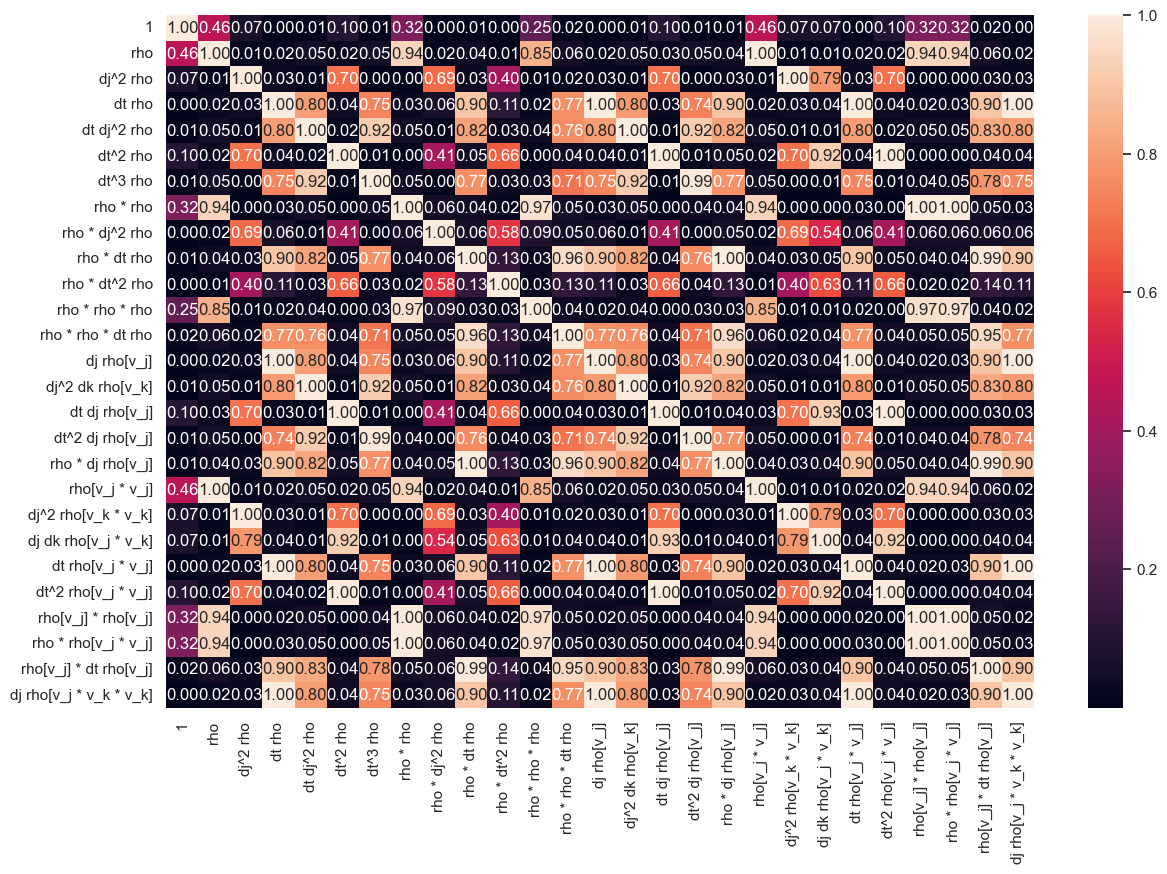

In [28]:
import seaborn as sns
%matplotlib inline
sns.set(rc={'figure.figsize':(14,9)})

# calculate the correlation matrix
R2 = (np.corrcoef(libs[0].Q, rowvar=False)**2)
# plot the heatmap
label_names = [str(term) for term in libs[0].terms]
sns.heatmap(R2, xticklabels=label_names, yticklabels=label_names, annot=True, fmt=".2f")

In [21]:
for i, term, size in zip(list(range(len(libs[0].terms))), libs[0].terms, libs[0].col_weights):
    print(i, term, size)
for i, term, size in zip(list(range(len(libs[1].terms))), libs[1].terms, libs[1].col_weights):
    print(i, term, size)

0 1 1
1 rho 1.000000470334876
2 dj^2 rho 0.9140569573371938
3 dt rho 0.9140569573371938
4 dt dj^2 rho 0.9140569573371938
5 dt^2 rho 0.9140569573371938
6 dt^3 rho 0.9140569573371938
7 rho * rho 1.000000940669973
8 rho * dj^2 rho 0.9140573872500595
9 rho * dt rho 0.9140573872500595
10 rho * dt^2 rho 0.9140573872500595
11 rho * rho * rho 1.0000014110052915
12 rho * rho * dt rho 0.9140578171631273
13 dj rho[v_j] 0.27031708296957674
14 dj^2 dk rho[v_k] 0.27031708296957674
15 dt dj rho[v_j] 0.27031708296957674
16 dt^2 dj rho[v_j] 0.27031708296957674
17 rho * dj rho[v_j] 0.2703172101091284
18 rho[v_j * v_j] 0.12500010148682966
19 dj^2 rho[v_k * v_k] 0.07994176375841003
20 dj dk rho[v_j * v_k] 0.07994176375841003
21 dt rho[v_j * v_j] 0.07994176375841003
22 dt^2 rho[v_j * v_j] 0.07994176375841003
23 rho[v_j] * rho[v_j] 0.1250001602787369
24 rho * rho[v_j * v_j] 0.1250001602787369
25 rho[v_j] * dt rho[v_j] 0.09557158249148832
26 dj rho[v_j * v_k * v_k] 0.02364144183046208
0 di rho 0.914056957337

In [15]:
continuity_terms = ['dt rho', 'dj rho[v_j]']
#continuity_terms = ['1', 'rho', 'rho * rho']
#continuity_terms = ['rho * rho[v_j * v_j]', 'rho[v_j] * rho[v_j]', 'rho']
#continuity_terms = ['rho * dt rho', 'rho * dj rho[v_j]']
#continuity_terms = ['dt rho * rho', 'rho * rho * dj v_j', 'dj rho * rho * v_j']
#continuity_terms = ['dt rho', 'dj rv_j']
col_numbers = [find_term(libs[0].terms, name) for name in continuity_terms]
Xi, lambd = regress(libs[0].Q, col_numbers)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[0].terms[i]}. (Char. size: {libs[0].col_weights[i]})")
print("Model residual:", lambd)

[Term 3] 0.9996480886234982 * dt rho. (Char. size: 0.9265463120486757)
[Term 13] 1.0 * dj rho[v_j]. (Char. size: 0.2740106010886393)
Model residual: 0.0006879949316046926


In [14]:
#burger_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]']
burger_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]', 'di rho']#, 'dj^2 rho[v_i]']# 'dj^2 rho[v_i]']
#burger_terms = ['dt rho[v_i]', 'rho * dj rho[v_i * v_j]', 'di rho']
col_numbers = [find_term(libs[1].terms, name) for name in burger_terms]
Xi, lambd = regress(libs[1].Q, col_numbers)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[1].terms[i]}. (Char. size: {libs[1].col_weights[i]})")
print("Model residual:", lambd)

[Term 0] -0.05456159138870624 * di rho. (Char. size: 0.9265463120486757)
[Term 10] 0.7314797192795808 * dt rho[v_i]. (Char. size: 0.2740106010886393)
[Term 19] 1.0 * dj rho[v_i * v_j]. (Char. size: 0.08103406007082894)
Model residual: 0.03895888153978483
